<a href="https://colab.research.google.com/github/khalidpark/project-RNN/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df1 = pd.read_csv('/content/실제진료정보_감기_시군구.csv', encoding='cp949')
df2 = pd.read_csv('/content/실제진료정보_눈병_시군구.csv', encoding='cp949')
df3 = pd.read_csv('/content/실제진료정보_천식_시군구.csv', encoding='cp949')
df4 = pd.read_csv('/content/실제진료정보_피부염_시군구.csv', encoding='cp949')

In [3]:
df1.head()

,날짜,시군구지역코드,발생건수(건)
0,20140101,11110,53
1,20140101,11140,55
2,20140101,11170,120
3,20140101,11200,192
4,20140101,11215,165


In [4]:
df2.head()

,날짜,시군구지역코드,발생건수(건)
0,20140101,11110,2
1,20140101,11140,1
2,20140101,11170,7
3,20140101,11200,9
4,20140101,11215,6


In [5]:
df = pd.concat([df1,df2['발생건수(건)'],df3['발생건수(건)'],df4['발생건수(건)']],axis=1)

In [6]:
df.head(10)

,날짜,시군구지역코드,발생건수(건),발생건수(건),발생건수(건),발생건수(건)
0,20140101,11110,53,2.0,7.0,4.0
1,20140101,11140,55,1.0,7.0,3.0
2,20140101,11170,120,7.0,11.0,2.0
3,20140101,11200,192,9.0,18.0,7.0
4,20140101,11215,165,6.0,17.0,5.0
5,20140101,11230,156,8.0,22.0,11.0
6,20140101,11260,211,7.0,26.0,13.0
7,20140101,11290,174,9.0,35.0,11.0
8,20140101,11305,185,10.0,69.0,10.0
9,20140101,11320,204,22.0,43.0,4.0


In [7]:
df.columns = ['Date','Code','Cold','Eye','Asthma','Dermatitis']

In [8]:
df.head()

,Date,Code,Cold,Eye,Asthma,Dermatitis
0,20140101,11110,53,2.0,7.0,4.0
1,20140101,11140,55,1.0,7.0,3.0
2,20140101,11170,120,7.0,11.0,2.0
3,20140101,11200,192,9.0,18.0,7.0
4,20140101,11215,165,6.0,17.0,5.0


In [9]:
df.shape

(619030, 6)

In [10]:
df.dtypes

Date            int64
Code            int64
Cold            int64
Eye           float64
Asthma        float64
Dermatitis    float64
dtype: object

In [11]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [12]:
df.dtypes

Date          datetime64[ns]
Code                   int64
Cold                   int64
Eye                  float64
Asthma               float64
Dermatitis           float64
dtype: object

In [13]:
df.head(10)

,Date,Code,Cold,Eye,Asthma,Dermatitis
0,2014-01-01,11110,53,2.0,7.0,4.0
1,2014-01-01,11140,55,1.0,7.0,3.0
2,2014-01-01,11170,120,7.0,11.0,2.0
3,2014-01-01,11200,192,9.0,18.0,7.0
4,2014-01-01,11215,165,6.0,17.0,5.0
5,2014-01-01,11230,156,8.0,22.0,11.0
6,2014-01-01,11260,211,7.0,26.0,13.0
7,2014-01-01,11290,174,9.0,35.0,11.0
8,2014-01-01,11305,185,10.0,69.0,10.0
9,2014-01-01,11320,204,22.0,43.0,4.0


In [14]:
# df = df[df['Code'] == 11110]

In [15]:
# df.head()

,Date,Code,Cold,Eye,Asthma,Dermatitis
0,2014-01-01,11110,53,2.0,7.0,4.0
254,2014-01-02,11110,1408,262.0,209.0,411.0
509,2014-01-03,11110,1129,352.0,330.0,408.0
763,2014-01-04,11110,890,276.0,503.0,351.0
1016,2014-01-05,11110,134,19.0,6.0,48.0


In [14]:
df.shape

(619030, 6)



---



데이터는 하루마다 기록됩니다

특정 요일이 주어졌을때 앞으로 7일 동안의 발생건수를 예측한다고 가정해봅니다

예측을 하기 위해 6일간의 데이터를 사용하도록 합니다

모형을 학습하기 위해 30(6*5) 개의 관측값이 포함된 window를 만듭니다

In [15]:
def cold_data_funciton(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [17]:
TRAIN_SPLIT = 400000
# 재현성을 보장하기 위해 시드 설정.
tf.random.set_seed(7)



---



# 예측1) 감기 시계열 예측

In [18]:
cold_data = df['Cold']
cold_data.index = df['Date']
cold_data.head()

Date
2014-01-01     53
2014-01-01     55
2014-01-01    120
2014-01-01    192
2014-01-01    165
Name: Cold, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbbe66bcd90>],
      dtype=object)

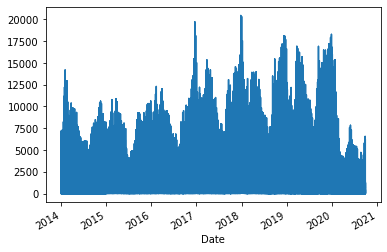

In [19]:
cold_data.plot(subplots=True)

In [20]:
cold_data = cold_data.values

In [21]:
cold_train_mean = cold_data[:TRAIN_SPLIT].mean()
cold_train_std = cold_data[:TRAIN_SPLIT].std()
# 데이터를 표준화합시다.
cold_data = (cold_data-cold_train_mean)/cold_train_std

모델에 마지막 20개의 관측치가 제공되며 다음 단계에서의 감기를 예측하는 방법

In [22]:
cold_past_history = 20
cold_future_target = 0

x_train_cold, y_train_cold = cold_data_funciton(cold_data, 0, TRAIN_SPLIT,
                                           cold_past_history,
                                           cold_future_target)
x_val_cold, y_val_cold = cold_data_funciton(cold_data, TRAIN_SPLIT, None,
                                       cold_past_history,
                                       cold_future_target)


In [23]:
print ('Single window of past history')
print (x_train_cold[0])
print ('\n Target temperature to predict')
print (y_train_cold[0])

Single window of past history
[[-0.92588852]
 [-0.92466567]
 [-0.88492282]
 [-0.84089997]
 [-0.85740854]
 [-0.86291139]
 [-0.82928283]
 [-0.85190568]
 [-0.84517997]
 [-0.83356283]
 [-0.64524286]
 [-0.76324855]
 [-0.84395711]
 [-0.81093997]
 [-0.75040856]
 [-0.62078572]
 [-0.73817999]
 [-0.86657996]
 [-0.84212283]
 [-0.82133426]]

 Target temperature to predict
-0.7815914073552783


In [24]:
def create_time_steps(length):
  return list(range(-length, 0))

In [25]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

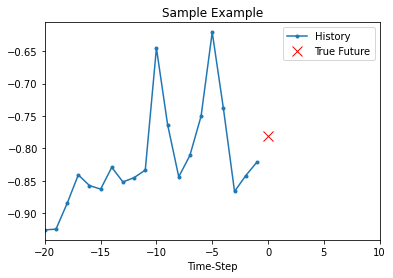

In [26]:
show_plot([x_train_cold[0], y_train_cold[0]], 0, 'Sample Example')



---



모델 학습을 진행하기 전 기준을 설정

In [27]:
def baseline(history):
  return np.mean(history)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

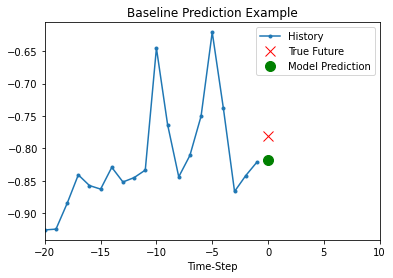

In [28]:
show_plot([x_train_cold[0], y_train_cold[0], baseline(x_train_cold[0])], 0,
           'Baseline Prediction Example')




---



In [29]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [30]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_rnn_cold = tf.data.Dataset.from_tensor_slices((x_train_cold, y_train_cold))
train_rnn_cold = train_rnn_cold.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_rnn_cold = tf.data.Dataset.from_tensor_slices((x_val_cold, y_val_cold))
val_rnn_cold = val_rnn_cold.batch(BATCH_SIZE).repeat()

In [31]:
simple_lstm_model = tf.keras.models.Sequential([
      # x_train_cold.shape = (299980, 20, 1)
    tf.keras.layers.LSTM(8, input_shape=x_train_cold.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [32]:
for x, y in val_rnn_cold.take(1):
    print(simple_lstm_model.predict(x).shape)


(256, 1)


In [33]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [34]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_rnn_cold, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_rnn_cold, validation_steps=50)


Epoch 1/10
200/200 [==============================] - 3s 7ms/step - loss: 0.8105 - val_loss: 0.5425
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4048 - val_loss: 0.4811
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4492 - val_loss: 0.4593
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4017 - val_loss: 0.4489
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3877 - val_loss: 0.4450
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4952 - val_loss: 0.4445
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4290 - val_loss: 0.4436
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5835 - val_loss: 0.4401
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4444 - val_loss: 0.4382
Epoch 10/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3890 - val_loss: 0.4352



---



간단한 LSTM을 학습 했으므로 몇 가지 예측을 시도

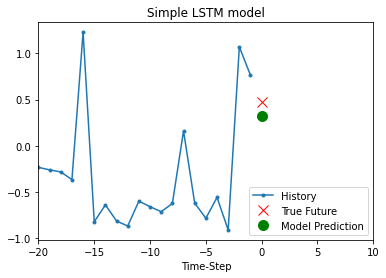

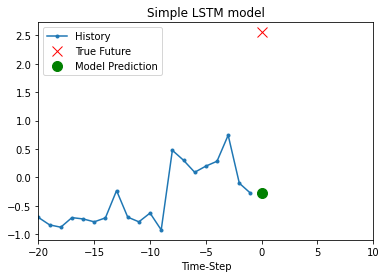

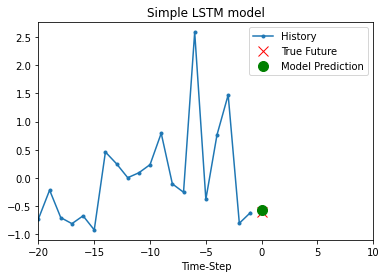

In [35]:
for x, y in val_rnn_cold.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()




---



#예측 2) 감기,눈병, 피부염, 천식 시계열 예측

In [36]:
features_considered = ['Cold','Eye','Asthma','Dermatitis']

In [37]:
features = df[features_considered]
features.index = df['Date']
features.head()

,Cold,Eye,Asthma,Dermatitis
Date,,,,
2014-01-01,53,2.0,7.0,4.0
2014-01-01,55,1.0,7.0,3.0
2014-01-01,120,7.0,11.0,2.0
2014-01-01,192,9.0,18.0,7.0
2014-01-01,165,6.0,17.0,5.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbbe09fe3d0>,
      dtype=object)

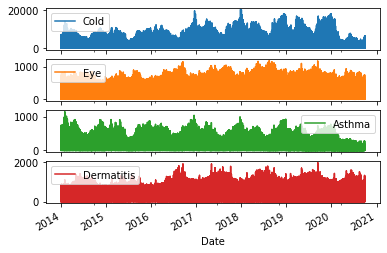

In [38]:
features.plot(subplots=True)


데이터 세트를 표준화

In [39]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
# 표준화
dataset = (dataset-data_mean)/data_std


In [40]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


In [41]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)


In [42]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (120, 4)


In [43]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()


In [44]:
train_data_single

<RepeatDataset shapes: ((None, 120, 4), (None,)), types: (tf.float64, tf.float64)>

In [45]:
val_data_single

<RepeatDataset shapes: ((None, 120, 4), (None,)), types: (tf.float64, tf.float64)>

In [46]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')


In [47]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [48]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=2)


Epoch 1/10
200/200 [==============================] - 4s 12ms/step - loss: 0.6426 - val_loss: 0.6850
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.5824 - val_loss: 0.6910
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.5386 - val_loss: 0.7026
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.5075 - val_loss: 0.7121
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5599 - val_loss: 0.5888
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.5112 - val_loss: 0.5587
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.5580 - val_loss: 0.5627
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 0.4853 - val_loss: 0.6298
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.5603 - val_loss: 0.5687
Epoch 10/10
200/200 [==============================] - 2s 11ms/step - loss: 0.4882 - val_los

In [49]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()


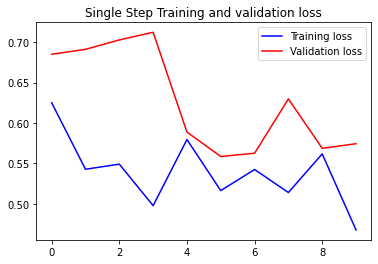

In [50]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')


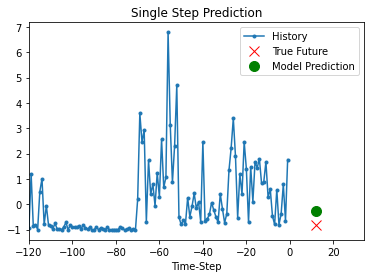

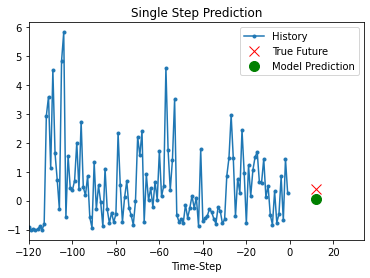

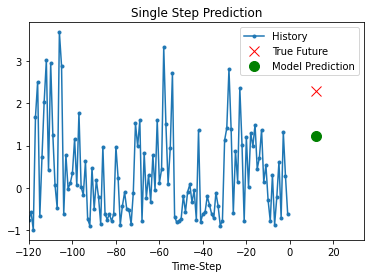

In [51]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()




---



모델 규제 추가

In [59]:
from tensorflow.keras.constraints import MaxNorm

#contraint 추가 , 옵티마이저 adam으로 변경

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(32,kernel_constraint=MaxNorm(2.)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss='mae',metrics=['accuracy'])
single_step_model.summary()

#########
# # 모델 구성을 확인합니다.
# model = Sequential([
#     Flatten(input_shape=(28, 28)),
#     Dense(64, input_dim=64,
#             kernel_regularizer=regularizers.l2(0.01),
#             activity_regularizer=regularizers.l1(0.01),
#             kernel_constraint=MaxNorm(2.)),             ## add constraints
#     Dense(10, activation='softmax')
# ])
# # 업데이트 방식을 설정합니다.
# model.compile(optimizer='adam'
#              , loss='sparse_categorical_crossentropy'
#              , metrics=['accuracy'])


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 19,777
Trainable params: 19,777
Non-trainable params: 0
_________________________________________________________________


In [60]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=2)

Epoch 1/10
200/200 [==============================] - 5s 15ms/step - loss: 0.6492 - accuracy: 0.0000e+00 - val_loss: 0.6848 - val_accuracy: 0.0000e+00
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5678 - accuracy: 0.0000e+00 - val_loss: 0.6733 - val_accuracy: 0.0000e+00
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5022 - accuracy: 0.0000e+00 - val_loss: 0.6781 - val_accuracy: 0.0000e+00
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.4610 - accuracy: 0.0000e+00 - val_loss: 0.6445 - val_accuracy: 0.0000e+00
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.4961 - accuracy: 0.0000e+00 - val_loss: 0.5851 - val_accuracy: 0.0000e+00
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.4513 - accuracy: 0.0000e+00 - val_loss: 0.5223 - val_accuracy: 0.0000e+00
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.4710 - accuracy: 

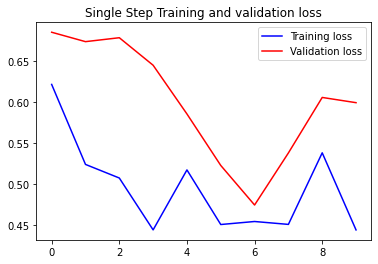

In [61]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')



---



In [62]:
from tensorflow.keras.layers import Dropout


In [63]:
# 드랍아웃 추가

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(32,kernel_constraint=MaxNorm(2.)))
single_step_model.add(tf.keras.layers.Dropout(0.5))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss='mae',metrics=['accuracy'])
single_step_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 64)                17664     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 19,777
Trainable params: 19,777
Non-trainable params: 0
_________________________________________________________________


In [64]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=2)

Epoch 1/10
200/200 [==============================] - 5s 15ms/step - loss: 0.6751 - accuracy: 0.0000e+00 - val_loss: 0.6837 - val_accuracy: 0.0000e+00
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5990 - accuracy: 0.0000e+00 - val_loss: 0.6890 - val_accuracy: 0.0000e+00
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5438 - accuracy: 0.0000e+00 - val_loss: 0.6785 - val_accuracy: 0.0000e+00
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5037 - accuracy: 0.0000e+00 - val_loss: 0.6655 - val_accuracy: 0.0000e+00
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5528 - accuracy: 0.0000e+00 - val_loss: 0.5986 - val_accuracy: 0.0000e+00
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5014 - accuracy: 0.0000e+00 - val_loss: 0.5364 - val_accuracy: 0.0000e+00
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5361 - accuracy: 

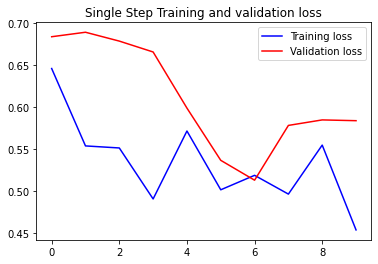

In [65]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')



---



In [70]:
df.head()

,Date,Code,Cold,Eye,Asthma,Dermatitis
0,2014-01-01,11110,53,2.0,7.0,4.0
1,2014-01-01,11140,55,1.0,7.0,3.0
2,2014-01-01,11170,120,7.0,11.0,2.0
3,2014-01-01,11200,192,9.0,18.0,7.0
4,2014-01-01,11215,165,6.0,17.0,5.0


In [71]:
df = df[df['Code'] == 11110]

In [72]:
df.head()

,Date,Code,Cold,Eye,Asthma,Dermatitis
0,2014-01-01,11110,53,2.0,7.0,4.0
254,2014-01-02,11110,1408,262.0,209.0,411.0
509,2014-01-03,11110,1129,352.0,330.0,408.0
763,2014-01-04,11110,890,276.0,503.0,351.0
1016,2014-01-05,11110,134,19.0,6.0,48.0


In [73]:
df.shape

(2465, 6)

In [74]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.25 ,random_state=1)
train.shape, test.shape

((1848, 6), (617, 6))

In [75]:
# features 와 target 을 분리

target = 'Cold'
features = df.drop(columns=[target]).columns

X_train = train[features]
X_test = test[features]

y_train = train[target]
y_test = test[target]

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

TypeError: ignored

In [107]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)


In [108]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))


Single window of past history : (30, 4)

 Target temperature to predict : (72,)


In [109]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [110]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


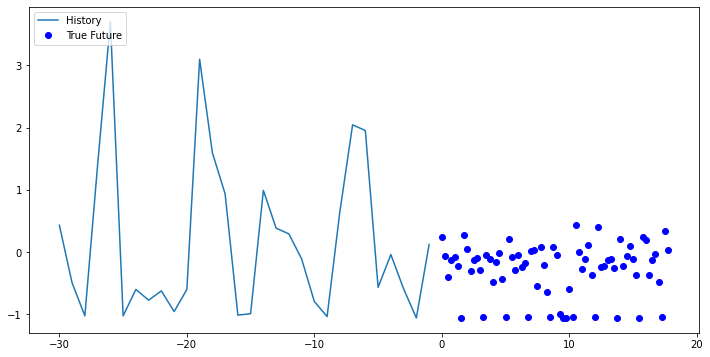

In [111]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))


In [112]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


In [113]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)


(256, 72)


In [114]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)


Epoch 1/10
200/200 [==============================] - 12s 49ms/step - loss: 0.5517 - val_loss: nan
Epoch 2/10
200/200 [==============================] - 9s 47ms/step - loss: 0.5021 - val_loss: nan
Epoch 3/10
200/200 [==============================] - 9s 46ms/step - loss: 0.4779 - val_loss: nan
Epoch 4/10
 51/200 [======>.......................] - ETA: 6s - loss: 0.4569

KeyboardInterrupt: ignored

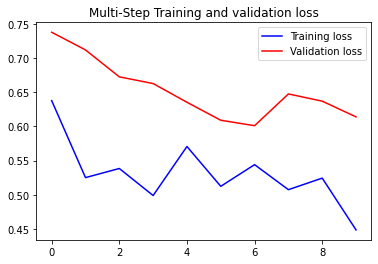

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

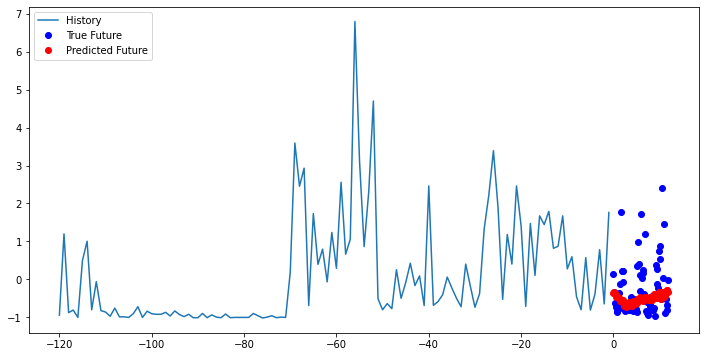

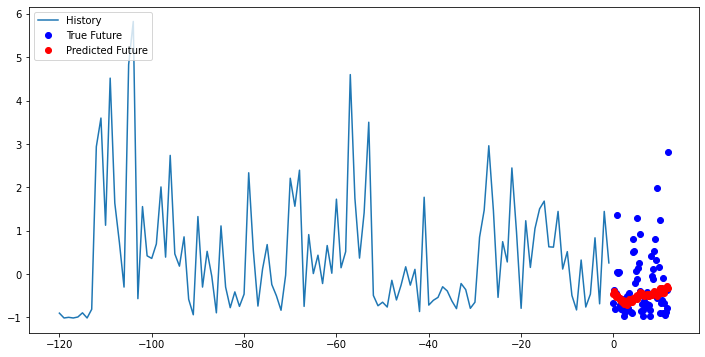

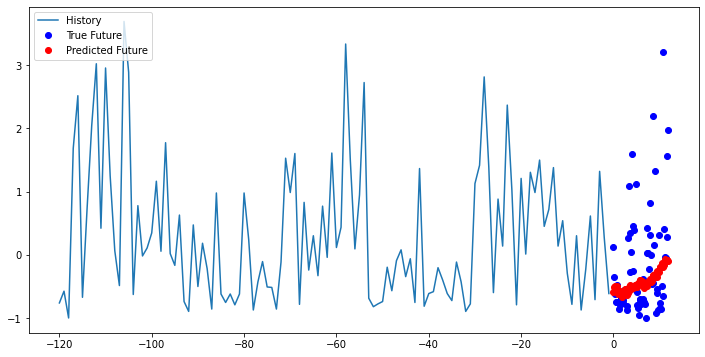

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
